In [ ]:
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from google.colab.patches import cv2_imshow
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tr=pd.read_csv('/content/drive/MyDrive/mps1/train-sf.csv')
tr

,22,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.534,0.535,0.536,0.537,0.538,0.539,0.540,0.541,0.542,0.543
0,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121383,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121384,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121385,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121386,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
targets=tr.pop(tr.columns[0])

In [ ]:
targets=targets.replace({10:0,11:1,12:2,14:3,15:4,16:5,17:6,20:7,22:8,23:9,25:10,26:11,27:12,28:13,29:14,32:15,33:16,34:17,35:18})

In [ ]:
df_in=torch.tensor(tr.to_numpy())
df_in=df_in.float()

In [ ]:
df_tar=torch.tensor(targets.to_numpy())

In [ ]:
df_tar.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])

In [ ]:
train_ds=TensorDataset(df_in,df_tar)

In [ ]:
train_ds[:3]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([14, 15,  8]))

In [ ]:
val_size = 10000
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(111388, 10000)

In [ ]:
batch_size=128
train_dl=DataLoader(train_ds,batch_size,shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [ ]:
input_size=28*28
num_classes=20

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size,hidden2_size,hidden3_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden2_size)
        self.linear3 = nn.Linear(hidden2_size, hidden3_size)
        # output layer
        self.linear4 = nn.Linear(hidden3_size, out_size)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear1(xb)
        out = F.relu(out)          # Apply activation function

        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    


In [ ]:
hidden_size=128
hidden2_size=64
hidden3_size=32
model = MnistModel(input_size, hidden_size, hidden2_size,hidden3_size,out_size=num_classes)

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
result = fit(50, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 0.6715, val_acc: 0.8105
Epoch [1], val_loss: 0.4988, val_acc: 0.8568
Epoch [2], val_loss: 0.4055, val_acc: 0.8875
Epoch [3], val_loss: 0.3881, val_acc: 0.8908
Epoch [4], val_loss: 0.3445, val_acc: 0.9050
Epoch [5], val_loss: 0.3273, val_acc: 0.9087
Epoch [6], val_loss: 0.2918, val_acc: 0.9208
Epoch [7], val_loss: 0.2802, val_acc: 0.9245
Epoch [8], val_loss: 0.2907, val_acc: 0.9211
Epoch [9], val_loss: 0.2749, val_acc: 0.9247
Epoch [10], val_loss: 0.2670, val_acc: 0.9271
Epoch [11], val_loss: 0.2608, val_acc: 0.9263
Epoch [12], val_loss: 0.2382, val_acc: 0.9346
Epoch [13], val_loss: 0.2230, val_acc: 0.9379
Epoch [14], val_loss: 0.2704, val_acc: 0.9203
Epoch [15], val_loss: 0.2192, val_acc: 0.9413
Epoch [16], val_loss: 0.2135, val_acc: 0.9408
Epoch [17], val_loss: 0.2147, val_acc: 0.9403
Epoch [18], val_loss: 0.2316, val_acc: 0.9338
Epoch [19], val_loss: 0.2101, val_acc: 0.9417
Epoch [20], val_loss: 0.2065, val_acc: 0.9438
Epoch [21], val_loss: 0.2093, val_acc: 0.941

In [ ]:
ts=pd.read_csv('/content/drive/MyDrive/mps1/test-sf.csv')
ts

,33,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.550,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559
0,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20123,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20124,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20125,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20126,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
targets1=ts.pop(ts.columns[0])

In [ ]:
targets1=targets1.replace({10:0,11:1,12:2,14:3,15:4,16:5,17:6,20:7,22:8,23:9,25:10,26:11,27:12,28:13,29:14,32:15,33:16,34:17,35:18})

In [ ]:
targets1.unique()

array([15,  2,  4,  7, 14, 13, 16, 10, 18,  3, 17, 11,  1, 12,  9,  0,  8,
        5,  6])

In [ ]:
ts_in=torch.tensor(ts.to_numpy())
ts_in=ts_in.float()

In [ ]:
ts_in.shape
ts_in

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Shape: torch.Size([1, 28, 28])
Label: 10 , Predicted: 10


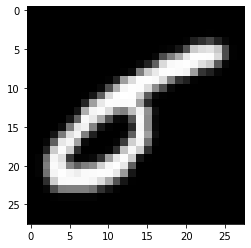

In [ ]:
img1 = ts_in[253]
img1 = img1.reshape(1,28,28)
plt.imshow(img1[0], cmap='gray')
print('Shape:', img1.shape)
print('Label:', targets1[253], ', Predicted:', predict_image(img1, model))

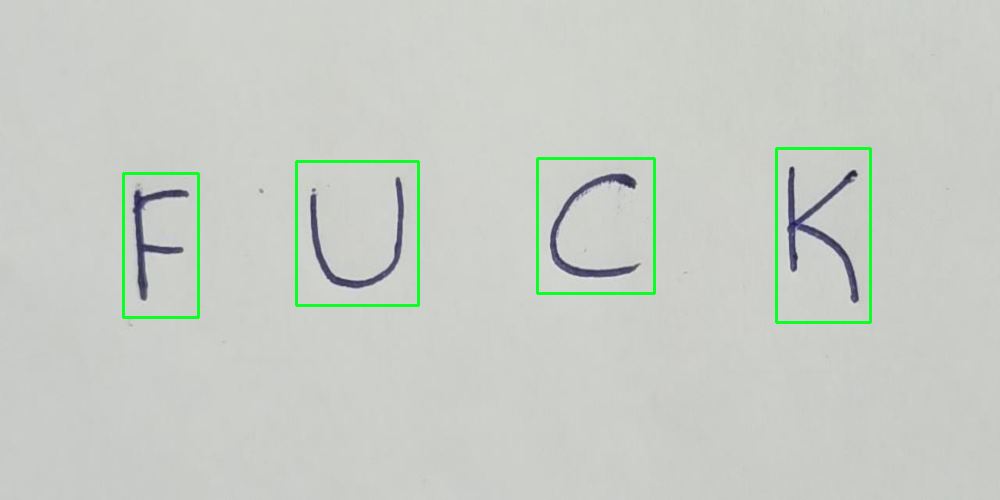

In [ ]:
# image = cv2.imread('kantesh.png')
# image = cv2.imread('abcd.jpeg')
# image = cv2.imread('kpqr.jpeg')
image = cv2.imread('fuck.jpeg')
# image = cv2.imread('captcha-1.jpg')
image = cv2.resize(image,(1000,500))
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
kernel = np.ones((5,5),np.uint8)
kernel1 = np.ones((3,3),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]


image_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if (h*w)<3000:
        continue
    elif (h*w)>3000:
        cv2.rectangle(image, (x-int(w/8), y-int(h/8)), (x + w+int(w/8), y + h+int(h/8)), (36,255,12), 2)
        ROI = original[y-int(h/8):y+h+int(h/8), x-int(w/8):x+w+int(w/8)]
        cv2.imwrite("ROI_{}.png".format(image_number), ROI)
        image_number += 1
    # else:
        # cv2.rectangle(image, (x-int(w), y-int(h)), (x + w + int(w), y + h + int(h)), (36,255,12), 2)
        # ROI = original[y-int(h):y+h+int(h), x-int(w):x+w+int(w)]
        # cv2.imwrite("ROI_{}.png".format(image_number), ROI)
        # image_number += 1

# cv2.imshow('gray', gray)
# cv2.imshow('dilate', dilate)
# cv2.imshow('canny', canny)
cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

def funarray2():
    a = []
    # print(image_number)
    for i in range(image_number):
        img = cv2.imread("ROI_"+str(i)+".png", 0)
        img = cv2.resize(img,(28,28))
        img = cv2.bitwise_not(img)
        ret , img = cv2.threshold(img,120,255,cv2.THRESH_TOZERO)
        img = cv2.dilate(img, kernel1, iterations=1)
        img=cv2.transpose(img)
        # def threshold_slow(T, image):
        #     # grab the image dimensions
        #     h = image.shape[0]
        #     w = image.shape[1]
            
        #     # loop over the image, pixel by pixel
        #     for y in range(0, h):
        #         for x in range(0, w):
        #             # threshold the pixel
        #             if (image[y, x] >= T):
        #                 image[y, x] = 255 
                    
        #     return image
        # img=threshold_slow(120,img)
  
        # print(img.shape)
        cv2_imshow(img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        img_ = img.flatten()
        # img = img.reshape(28*28)
    
        a.append(img_)
    return a

x_train = funarray2()
x_train1 = np.array(x_train)
# print(x_train1)

In [ ]:
ts_in1=torch.tensor(x_train1)
ts_in1=ts_in1.float()
print(ts_in1.shape)
ts_in1

torch.Size([4, 784])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
# img2 = ts_in1[3]
# img2 = img2.reshape(1,28,28)
# plt.imshow(img2[0], cmap='gray')
# print('Shape:', img2.shape)
# print('Predicted:', predict_image(img2, model))

In [ ]:
op=""
for i in range(image_number):
  img2 = ts_in1[i]
  img2 = img2.reshape(1,28,28)
  img3 = np.array(img2.reshape(28,28))
  #plt.imshow(img2[0], cmap='gray')
  cv2_imshow(img3)
  #print('Shape:', img2.shape)
  prediction_=predict_image(img2, model)
  #print('Predicted:', prediction_)
  transdict = {0:'A',1:'B',2:'C',3:'E',4:'F',5:'G',6:'H',7:'K',8:'M',9:'N',10:'P',11:'Q',12:'R',13:'S',14:'T',15:'W',16:'X',17:'Y',18:'Z',19:'7',20:'1',21:'2',22:'3',23:'4',24:'5',25:'6'}
  op+=(transdict[prediction_])
print("Your Captcha is:",op)

NameError: ignored

In [ ]:
torch.save(model,'letters-f.h5')